In [1]:
from fastai.vision.all import *
from fastai.torch_core import TensorMask, TensorImage

# from fastai.callback.core import Callback
# from fastai.data.core import DataLoaders
import rasterio as rio
import timm
import torch
import fastai
from rasterio.enums import Resampling
import torch.multiprocessing
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [2]:
# print(torchvision.__version__)
print(torch.__version__)
print(fastai.__version__)
print(default_device())

2.0.0.post200
2.7.12


In [4]:
# Define a list of dictionaries containing model types and batch sizes to train
model_details = {"model_type": "regnety_006", "fp_16": True, "lr": 1e-3}

In [5]:
model_details["model_type"]

'regnety_006'

In [6]:
model_version = "1.09"  # Assigns string value to model_version
model_name = f"{model_details['model_type']}_v{model_version}_model"  # Assigns string value to model_name
model_name

'regnety_006_v1.09_model'

In [7]:
time_steps = 6

In [8]:
# limited_band_read_list = [1, 2, 3, 4, 5, 6]
limited_band_read_list = list(range(1, 4 * time_steps + 1))
limited_band_read_list

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24]

In [9]:
limited_band_read_list = [
    # 1,
    2,
    # 3,
    4,
    #  5,
    6,
    # 7,
    8,
    #  9,
    10,
    # 11,
    12,
    #  13,
    14,
    # 15,
    16,
    #  17,
    18,
    # 19,
    20,
    #  21,
    22,
    # 23,
    24,
]

In [10]:
bands_per_timestep = int(len(limited_band_read_list) / time_steps)
bands_per_timestep

2

In [11]:
# Define paths to image and mask directories

path = Path("/media/nick/SNEAKERNET/training data")
label_path = path / "labels"

# images_path = path / "images"
images_path = path / "images"

In [12]:
bs = [64, 32, 16]
epochs = 20

In [13]:
# Define a list of dictionaries for the various model sizes to be trained
model_params = [
    {
        "name": model_name + "_40m",
        "size": 128,
        "epochs": epochs,
        "lr": model_details["lr"],
        "fp_16": model_details["fp_16"],
        "bs": bs[0],
    },
    {
        "name": model_name + "_20m",
        "size": 256,
        "epochs": epochs,
        "lr": model_details["lr"],
        "fp_16": model_details["fp_16"],
        "bs": bs[1],
    },
]

model_params

[{'name': 'regnety_006_v1.09_model_40m',
  'size': 128,
  'epochs': 20,
  'lr': 0.001,
  'fp_16': True,
  'bs': 64},
 {'name': 'regnety_006_v1.09_model_20m',
  'size': 256,
  'epochs': 20,
  'lr': 0.001,
  'fp_16': True,
  'bs': 32}]

In [14]:
def label_func(label_path, file_path):
    label_path = label_path / file_path.name

    return label_path

In [15]:
# func to get img list to use excluding the bad images
def get_image_files_custom(source, p=False):
    return list(source.glob("[!.]*.tif"))

In [16]:
f_names = list(get_image_files_custom(images_path))
len(f_names)

1480

In [17]:
f_names[0]

Path('/media/nick/SNEAKERNET/training data/images/318_OSM_80.tif')

In [18]:
mean = 0.06330473795822207
std = 0.02668270641026416

In [19]:
mean_subset = []
std_subset = []
for i in limited_band_read_list:
    mean_subset.append(mean)
    std_subset.append(std)
mean_subset

[0.06330473795822207,
 0.06330473795822207,
 0.06330473795822207,
 0.06330473795822207,
 0.06330473795822207,
 0.06330473795822207,
 0.06330473795822207,
 0.06330473795822207,
 0.06330473795822207,
 0.06330473795822207,
 0.06330473795822207,
 0.06330473795822207]

In [20]:
validation_paths = []
for i in range(8):
    file = images_path / f"{i}_Aus.tif"
    validation_paths.append(file)
    print(file.exists())
    # validation_paths.append()
validation_paths

True
True
True
True
True
True
True
True


[Path('/media/nick/SNEAKERNET/training data/images/0_Aus.tif'),
 Path('/media/nick/SNEAKERNET/training data/images/1_Aus.tif'),
 Path('/media/nick/SNEAKERNET/training data/images/2_Aus.tif'),
 Path('/media/nick/SNEAKERNET/training data/images/3_Aus.tif'),
 Path('/media/nick/SNEAKERNET/training data/images/4_Aus.tif'),
 Path('/media/nick/SNEAKERNET/training data/images/5_Aus.tif'),
 Path('/media/nick/SNEAKERNET/training data/images/6_Aus.tif'),
 Path('/media/nick/SNEAKERNET/training data/images/7_Aus.tif')]

In [21]:
def is_valid_file(x, validation_paths):
    return x in validation_paths

In [22]:
torch.zeros(12, 128, 128).shape

torch.Size([12, 128, 128])

In [23]:
class Switcheroo(RandTransform):
    "Randomly switch the order of the time steps, keeping the band order the same"

    split_idx, order = 0, 2

    def __init__(self, p=1, bands_per_timestep=2, time_steps=3):
        super().__init__(p=p)
        self.bands_per_timestep = bands_per_timestep
        self.time_steps = time_steps

    def encodes(self, x: (TensorImage)):
        new_time_step_order = torch.randperm(self.time_steps)
        new_order = [
            (i * self.bands_per_timestep) + j
            for i in new_time_step_order
            for j in range(self.bands_per_timestep)
        ]
        return x[:, new_order]

In [24]:
class BatchRot90(RandTransform):
    "Rotate image and mask by 0, 90, 180, or 270 degrees"
    split_idx, order = 0, 2

    def __init__(self, p=1):
        super().__init__(p=p)
        self.rots = 0

    def before_call(self, b, split_idx):
        if random.random() < self.p:
            self.rot = random.choice([0, 1, 2, 3])
        else:
            self.rot = 0

    def encodes(self, x: (TensorImage, TensorMask)):
        return x.rot90(self.rot, [-2, -1])

In [25]:
def open_mask(img_path, img_size):
    with rio.open(img_path) as src:
        raw_bands = src.read(
            1, out_shape=(img_size, img_size), resampling=Resampling.nearest
        )
    return TensorMask(torch.from_numpy(raw_bands))

In [26]:
image_cache = {}

In [27]:
def open_img(img_path, img_size):
    if img_path in image_cache:
        return image_cache[img_path]
    with rio.open(img_path) as src:
        raw_bands = src.read(limited_band_read_list, out_shape=(img_size, img_size))
    tensor_img = (
        TensorImage(torch.from_numpy(raw_bands.astype("float16"))).half().cuda()
    )
    image_cache[img_path] = tensor_img
    return tensor_img

In [28]:
for i in tqdm(f_names):
    open_img(i, 256)
    # break

  0%|          | 0/1480 [00:00<?, ?it/s]

In [29]:
# build datablock
def build_dblock(img_size):
    open_img_partial = partial(open_img, img_size=img_size)
    open_mask_partial = partial(open_mask, img_size=img_size)
    lable_func_partial = partial(label_func, label_path)

    dblock = DataBlock(
        blocks=(
            TransformBlock(open_img_partial),
            TransformBlock(open_mask_partial),
            # MaskBlock(),
        ),
        get_items=get_image_files_custom,
        get_y=lable_func_partial,
        splitter=FuncSplitter(lambda x: is_valid_file(x, validation_paths)),
        batch_tfms=[
            IntToFloatTensor(32767, 1),
            *aug_transforms(
                flip_vert=True,
                max_rotate=0,
                max_zoom=0.2,
                max_lighting=0.2,
                max_warp=0,
                p_affine=0,
                p_lighting=0.2,
                size=img_size,
            ),
            BatchRot90(),
            Switcheroo(bands_per_timestep=bands_per_timestep, time_steps=time_steps),
            Normalize.from_stats(mean=mean_subset, std=std_subset),
        ],
    )
    return dblock

In [30]:
# dblock = build_dblock(model_params[2]['size'],l1c_mean,l1c_std,l2a_mean,l2a_std)
dblock = build_dblock(model_params[1]["size"])

dl = dblock.dataloaders(
    size=model_params[1]["size"],
    source=images_path,
    bs=40,
    seed=42,
    num_workers=0,
)

In [31]:
ob = dl.one_batch()

In [32]:
dl.one_batch()[0].shape

torch.Size([40, 12, 256, 256])

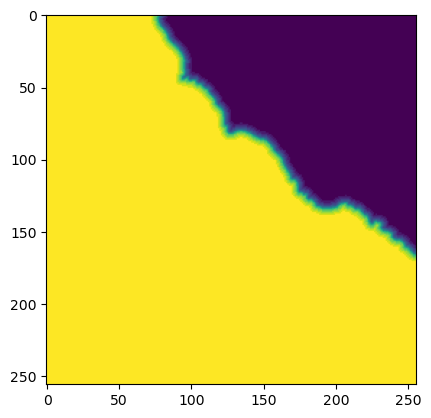

In [33]:
plt.imshow(ob[1].cpu().numpy()[0])

In [34]:
timm_model = partial(
    timm.create_model,
    model_details["model_type"],
    pretrained=True,
    in_chans=dl.one_batch()[0].shape[1],
)

In [35]:
learner = unet_learner(
    dl, timm_model, pretrained=True, loss_func=MSELossFlat(), n_out=1
).to_fp16()

In [36]:
learner.fine_tune(
    freeze_epochs=5,
    epochs=20,
)

epoch,train_loss,valid_loss,time
0,29.150776,18.842812,00:20
1,18.059155,8.636269,00:19
2,12.127446,7.074185,00:19
3,10.956532,9.710376,00:19
4,8.934980,5.866927,00:19


epoch,train_loss,valid_loss,time
0,5.338074,4.412167,00:20
1,4.625685,3.150917,00:20
2,4.325428,3.442883,00:20
3,4.230660,2.931870,00:20
4,4.616123,3.470397,00:21
5,4.695312,3.006668,00:21
6,4.478568,3.178866,00:21
7,4.088382,3.775169,00:20
8,3.771723,3.503386,00:20
9,3.809219,2.469727,00:20


In [37]:
# 1.1

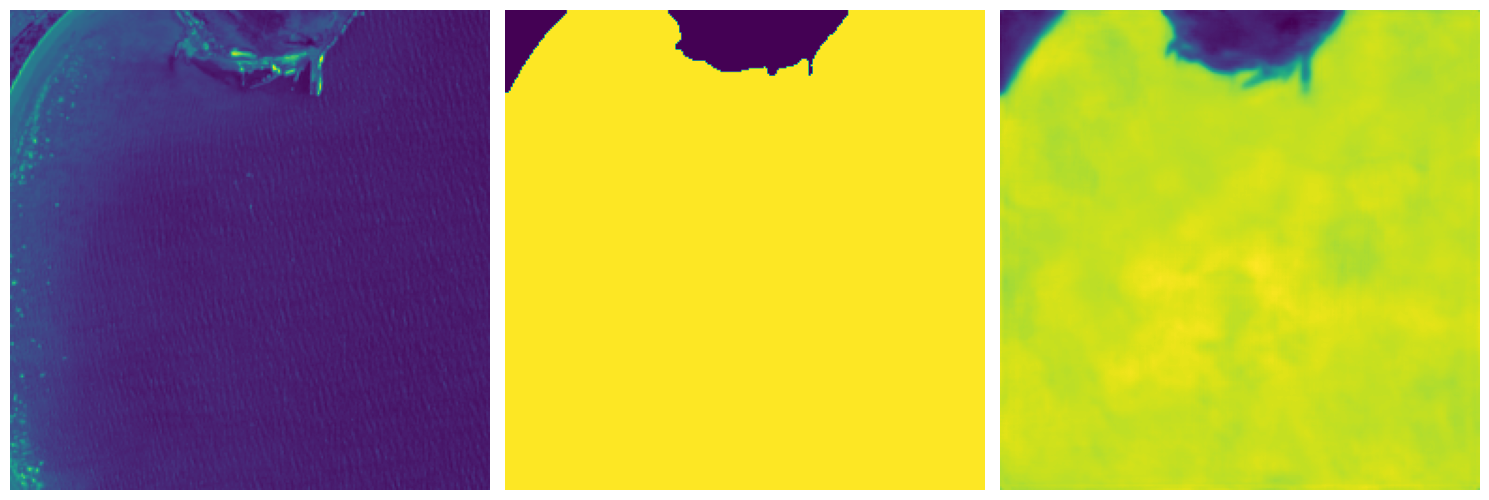

In [38]:
img_numb = 1
p = learner.predict(validation_paths[img_numb], with_input=True)

fig, axes = plt.subplots(1, 3, figsize=(15, 7))  # 1 row, 3 columns
axes[0].imshow(p[0].numpy()[2])
axes[0].axis("off")
axes[1].imshow(p[1].numpy()[0] > 0)
axes[1].axis("off")
axes[2].imshow(p[1].numpy()[0])
axes[2].axis("off")
plt.tight_layout()

In [39]:
pickle.dump(learner.model, open(f"{model_name}.pkl", "wb"))

In [40]:
f"{model_name}.pkl"

'regnety_006_v1.09_model.pkl'